In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from UKMovementSensing import hsmm
from milleniumcohort import create_config

In [4]:
config = create_config('../config.yml')
config.create_data_paths()

In [5]:
import sqlite3
conn = sqlite3.connect(os.path.join(config.model_path, 'milleniumcohort.db'))

## Load data in database

In [6]:
config.model_path

'/media/sf_VBox_Shared/London/london_data_19Mei2017/results/mod_4st_0b_15r_720t_acceleration_anglex_angley_anglez'

In [7]:
# Import data with states
filenames = os.listdir(config.states_path)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(config.states_path,fn))]

In [ ]:
# Only do this if database is not filled yet!
fill_again = False
if(fill_again):
    c = conn.cursor()
    c.execute('drop table if exists data_with_states')
    for fn in filenames:
        dataset = pd.read_csv(os.path.join(config.states_path,fn), encoding='utf-8', index_col='timestamp', parse_dates=True)
        dataset.to_sql('data_with_states', conn, if_exists='append')


In [ ]:
pd.read_sql('Select * from data_with_states limit 50', conn)

In [ ]:
pd.read_sql('Select count(distinct filename), count(*) from data_with_states', conn)

In [ ]:
pd.read_sql('pragma table_info(data_with_states)', conn)

## Preperation

In [ ]:
states = pd.read_sql('Select distinct state from data_with_states', conn)

In [ ]:
len(states)

In [ ]:
#Define consistent colormap
from matplotlib.colors import LinearSegmentedColormap
# One more than the number of states, so we have a color for 'All'
nr_states = len(states)
colormap, cmap = hsmm.get_color_map(nr_states+1)
cmap_states = LinearSegmentedColormap.from_list('name',
                                             [colormap[i] for i in range(nr_states)],
                                             nr_states)

In [ ]:
# Load simplified activities map
activities_simplified = pd.read_csv(config.activities_simplified_path, header=0, sep=',', dtype=str, encoding='utf-8')
levelmap = {'0': "low", '1': "high", '2':"mixed"}
def get_category_des(motion, arm_changes):
    return levelmap[motion]+" motion, " + levelmap[arm_changes] + " arm changes"
activities_simplified['simplified_category'] = [get_category_des(row[1], row[2]) for row in activities_simplified.get_values()]
activities_simplified.to_sql('activities_simplified', conn)

In [8]:

heuristic_classes = ['1 - no activity',  #1
                     '2 - inactivity', #2
                     '3 - light activity', #3 
                     '4 - vigorous activity', #4
                    '5 - MVPA at least 10 min', #5
                    '6 - MVPA 1-10 min', #6
                    '7 - inactivity at least 30min'] #7 
get_heuristic = lambda i: heuristic_classes[int(i)-1]

## Get subjects with >20 hour data

In [ ]:
timecounts = pd.read_sql('Select filename, count(*) from data_with_states group by filename', conn)

In [ ]:
timecounts = timecounts.set_index('filename')
timecounts.columns = ['cnt_5sec']
timecounts['cnt_hours'] = timecounts['cnt_5sec'] / (12.0 * 60)

In [ ]:
timecounts.to_sql('timecounts', conn)

In [ ]:
longdays = timecounts[timecounts['cnt_hours']>=24].index
longdays.shape

## Calculate per-state statistics

In [ ]:
numerical_columns = ['acceleration','EN',
        'anglex','angley',u'anglez',u'roll_med_acc_x',u'roll_med_acc_y',
        u'roll_med_acc_z',u'dev_roll_med_acc_x',
             u'dev_roll_med_acc_y',u'dev_roll_med_acc_z']
query = '''Select state, ''' +  ','.join(['avg({})'.format(co) for co in numerical_columns]) + '''
from data_with_states group by state'''

avg_bystate = pd.read_sql(query, conn)

In [ ]:
avg_bystate = avg_bystate.set_index('state').transpose()
avg_bystate.index = numerical_columns

In [ ]:
means = avg_bystate.loc[config.hsmmconfig.column_names]
means.style.background_gradient(cmap='coolwarm',axis=1)

In [ ]:
avg_bystate.style.background_gradient(cmap='coolwarm',axis=1)

In [9]:
#Create random sample to do calculations on
sample = pd.read_sql(
    '''select state, heuristic, acceleration, anglex, angley, anglez
        from data_with_states
        where abs(random()%1) < 0.1 
    ''', conn)

In [10]:
sample.shape

(24278040, 6)

In [11]:
sample['cut-off'] = [get_heuristic(i) for i in sample['heuristic']]

/home/dafne/anaconda2/envs/ucl2/lib/python2.7/site-packages/pandas/core/frame.py:5945: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


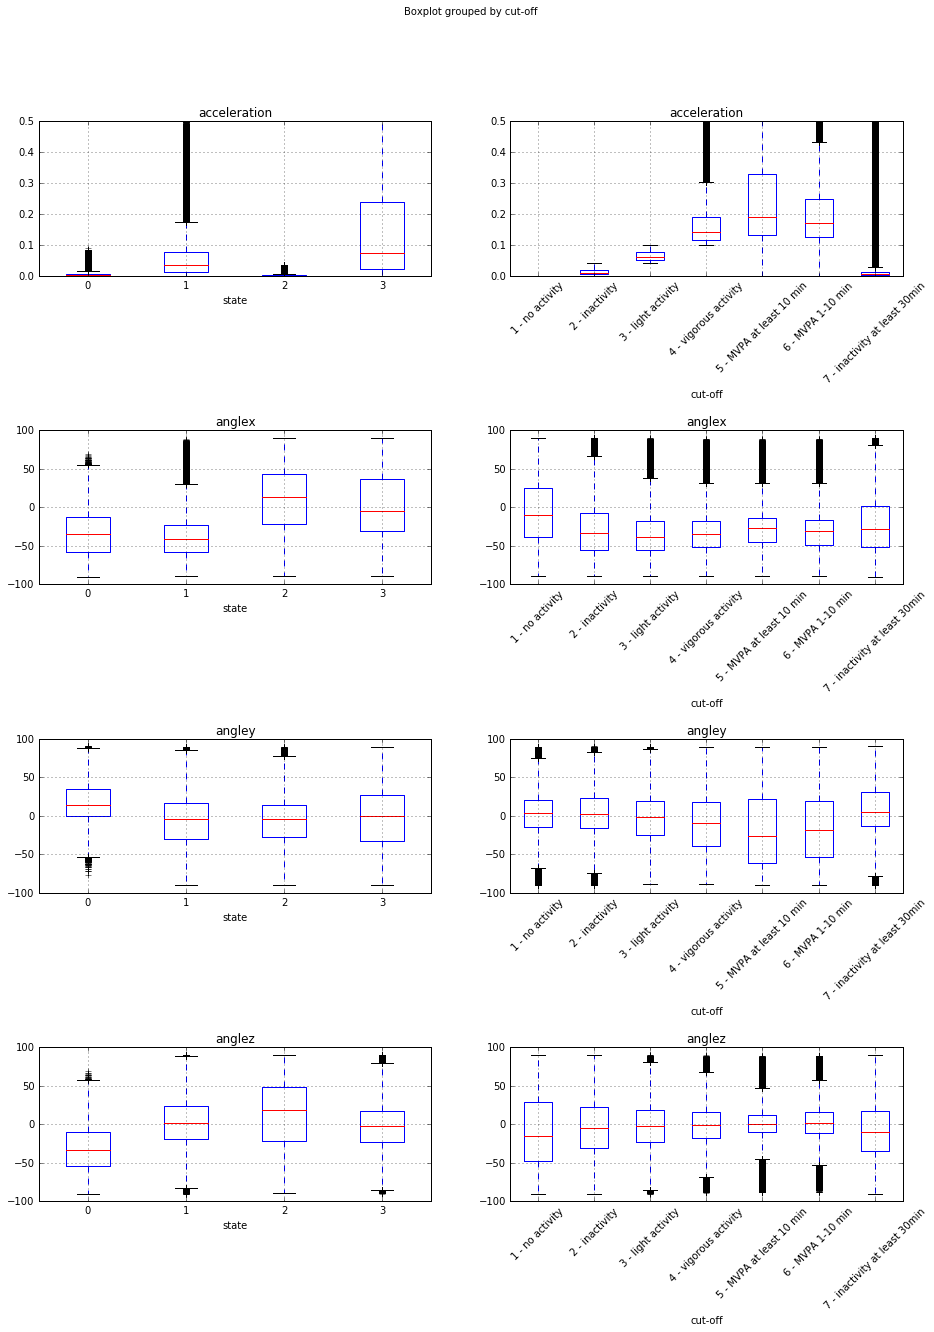

In [12]:
cols = ['acceleration', 'anglex', 'angley', 'anglez']
fig, axes = plt.subplots(len(cols), 2, figsize=(15, 20))
plt.subplots_adjust(hspace=1)
fig.set_label('')
sample.boxplot(by='state', column=cols, ax=axes[:,0])
sample.boxplot(by='cut-off', column=cols, ax=axes[:, 1], rot=45)
ymax_acc = 0.5
axes[0, 0].set_ylim(0, ymax_acc)
axes[0, 1].set_ylim(0, ymax_acc)
plt.savefig(os.path.join(config.image_path, 'boxplots.png'))

## Get sojourn times

In [ ]:
data_sc = pd.read_sql('''select filename, subset, state, heuristic from data_with_states''', conn) 

In [ ]:
data_sc['fn_s'] = data_sc['subset'].astype('str') + data_sc['filename']

In [ ]:
def sojourn_times(df, colname):
    changepoints = (df[colname].shift(1) != df[colname]) | (df.fn_s.shift(1) != df.fn_s)
    df['block'] = changepoints.astype(int).cumsum()
    sojourn_times = df.groupby([colname, 'block'])['fn_s'].count()
    sojourn_times = sojourn_times.reset_index()[[colname, 'fn_s']]
    sojourn_times.columns = [colname, 'time']
    df.drop('block', 1)
    return sojourn_times

In [ ]:
sojourn_times_state = sojourn_times(data_sc, 'state')

In [ ]:
sojourn_times_cutoff = sojourn_times(data_sc, 'heuristic')

In [ ]:
sojourn_times_state['time_sec'] = sojourn_times_state['time']*5
sojourn_times_cutoff['time_sec'] = sojourn_times_cutoff['time']*5
sojourn_times_state['time_min'] = sojourn_times_state['time']/12.0
sojourn_times_cutoff['time_min'] = sojourn_times_cutoff['time']/12.0

In [ ]:
sojourn_times_cutoff['cut-off'] = [get_heuristic(i) for i in sojourn_times_cutoff['heuristic']]

In [ ]:
sojourn_times_cutoff.head()

In [ ]:
s_grouped = sojourn_times_state.groupby('state')['time_sec']
pd.concat((s_grouped.mean(), s_grouped.std(), s_grouped.max()), axis=1, keys=['mean', 'sigma', 'max'])

In [ ]:
from matplotlib.ticker import FormatStrFormatter
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
fig.set_label('')
ymax = 60*60
sojourn_times_state.boxplot(by='state', column='time_sec', ax=axes[0])
axes[0].set_ylim(top=ymax)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%d sec'))
axes[0].set_title('sojourn time per state')
sojourn_times_cutoff.boxplot(by='cut-off', column='time_sec', ax=axes[1], rot=45)
axes[1].set_ylim(top=ymax)
axes[1].set_title('sojourn time per cut-off category')
plt.savefig(os.path.join(config.image_path, 'sojourn.png'))
#plt.show()

## Cross table activity - state

Let's compare the states with the known activities. First we have look at how many 5-seconds frame we have for each state/activity, and we sort from largest to smallest

In [ ]:
ctab_long = pd.read_sql('''select label, state, count(*) from data_with_states group by label, state''', conn) 

In [ ]:
ctab = ctab_long.pivot(index='label', columns='state', values='count(*)')

In [ ]:
activities_simplified

In [ ]:
ctab_merged = ctab_long.merge(activities_simplified, left_on='label', right_on='Label')
ctab_simplified_long = ctab_merged.groupby(['simplified_category', 'state'])[['count(*)']].sum()
ctab_simplified = ctab_simplified_long.reset_index().pivot(index='simplified_category', columns='state', values='count(*)')

In [ ]:
ctab_simplified

In [ ]:
from __future__ import unicode_literals
fig, ax = plt.subplots(figsize=(15,30))

states = ctab.columns
acts = ctab.index

n_groups = len(acts)
index = len(states)*np.arange(n_groups)
bar_width = 1./len(states)*3
colors = colormap

#Draw all states, but don't draw All
for i in range(len(states)):
    rects1 = plt.barh(index + i*bar_width, 
                     ctab[states[i]], 
                     bar_width,
                     color=colors[i],
                     label=states[i])

plt.yticks(index + bar_width, ctab.index, fontsize=15)
plt.legend()

#Set maximum to something reasonable, namely the maximum of not-all
#ax.set_xlim(0, ctab[states[-1]][acts[1]])
plt.show()

In [ ]:
#Now normalize over the activity and sort by total number
ctab_norm1 = ctab_simplified.copy()
ctab_norm1.loc['All',:] = ctab_norm1.sum()
ctab_norm1 = ctab_norm1.divide(ctab_norm1.sum(axis=1), axis='index')

In [ ]:
ctab_norm1.style.background_gradient(cmap='BuGn',axis=1)

In [ ]:
ctab_norm1.to_clipboard()

In [ ]:
ctab_norm2 = ctab_simplified.copy()
ctab_norm2['All'] = ctab_norm2.sum(axis=1)
ctab_norm2.divide(ctab_norm2.sum(axis=0), axis='columns')

In [ ]:
#Now normalize over state and sort by total number
#ind = list(ctab.index)
ctab_norm2 = ctab_simplified.copy()
ctab_norm2.loc['All'] = ctab_norm2.sum(axis=0)
ctab_norm2 = ctab_norm2.divide(ctab_norm2.sum(axis=1), axis='rows')

In [ ]:
ctab_norm2.style.background_gradient(cmap='BuGn',axis=0)

Check if there is a significant correlation between the states and the activities:

In [ ]:
ctab['All'] = ctab.sum(axis=1)
ctab = ctab.sort_values('All', ascending=False)

In [ ]:
topactivities = 10 # take most frequent activities
counts = ctab.as_matrix()[1:1+topactivities,:-1]
chi2, p, dof, expected = scipy.stats.chi2_contingency(counts)

print(chi2, p)

In [ ]:
ctab.head(10)

In [ ]:
# Only easy interpreted activities
activities = ['Sleeping and resting (including sick in bed)', 'Jogging, running, walking, hiking']
ctab[[a in activities for a in ctab.index]]

## Compare with heuristic

In [ ]:
ctab_heuristic_long = pd.read_sql('''select heuristic, state, count(*) from data_with_states group by heuristic, state''', conn)

In [ ]:
ctab_heuristic = ctab_heuristic_long.pivot(index='heuristic', columns='state', values='count(*)').fillna(0)

In [ ]:
ctab_heuristic.index = [get_heuristic(i) for i in ctab_heuristic.index]

In [ ]:
ctab_heuristic_norm = ctab_heuristic.divide(ctab_heuristic.sum(axis=0), axis=1)
ctab_heuristic_norm.style.background_gradient(cmap='BuGn',axis=0)

In [ ]:
ctab_heuristic_norm = ctab_heuristic.divide(ctab_heuristic.sum(axis=1), axis=0)
ctab_heuristic_norm.style.background_gradient(cmap='BuGn',axis=1)

## Heuristic vs states, per person

In [ ]:
heuristic_states = pd.read_sql('''select d.filename, d.state, d.heuristic, count(*)
                from data_with_states d
                join timecounts t
                on t.filename = d.filename
                where t.cnt_hours > 20
                group by d.filename, d.state, d.heuristic;''', 
                               conn)

In [ ]:
nr_subjects = len(heuristic_states['filename'].unique())
ctab = heuristic_states.groupby(['state', 'heuristic'])['count(*)'].sum()
ctab = ctab / nr_subjects
ctab = ctab.unstack(level=-1)
ctab = ctab.fillna(0)
ctab['total'] = heuristic_states.groupby(['state'])['count(*)'].sum() / nr_subjects
ctab.loc['total',] = ctab.sum(axis=0) 
ctab.applymap(lambda c: float(c)/nr_subjects)
ctab = ctab.applymap(lambda c: '{:.0f} min'.format(c/12.0))
ctab.columns = [get_heuristic(i) for i in ctab.columns[:-1]] + ['total']

In [ ]:
ctab

## Distributions for the heuristic levels

## States for an example sequence

In [ ]:
example_index = 674

In [ ]:
fn = filenames[example_index]
data = pd.read_csv(os.path.join(config.states_path,fn), encoding='utf-8', index_col='timestamp', parse_dates=True)
data.head()

In [ ]:
hidden_states = data['state']

In [ ]:
hsmm.plot_states_and_var(data, hidden_states, columns=['acceleration',], by='activity', cmap=cmap_states);
#plt.show()

In [ ]:
start =int(6*12*60)
end = 8*12*60
print(data[start:end].shape)
fig, ax = hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['acceleration'], by=None)
ax.set_title('acceleration')

In [ ]:
start =int(8*12*60)
end = 9*12*60
hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['acceleration'], by='activity')

In [ ]:
hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['anglex', 'angley', 'anglez'], by='activity')